# Dutch language model

In this notebook contains the implementation of fastai to train a Language Model on the Dutch Wiki text. For training purposes I only used an extract of approximately 1 GB to train on.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

# Data Preparation

In [5]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = Path('data/dutch-wiki-xml/raw/extractMedium/') #940 MB wiki text
path = PATH

In [6]:
LM_PATH= Path("data/dutch-wiki-xml/model/")
LM_PATH.mkdir(parents=True, exist_ok=True)
LM_PATH.ls()

[PosixPath('data/dutch-wiki-xml/model/Wiki_Dutch_Corpus2_medium.csv'),
 PosixPath('data/dutch-wiki-xml/model/lm_dutch_v2_3_enc.h5'),
 PosixPath('data/dutch-wiki-xml/model/models'),
 PosixPath('data/dutch-wiki-xml/model/Wiki_Dutch_Corpus_medium.csv'),
 PosixPath('data/dutch-wiki-xml/model/train_medium.csv'),
 PosixPath('data/dutch-wiki-xml/model/lm_dutch_v2_2.h5'),
 PosixPath('data/dutch-wiki-xml/model/itos.pkl'),
 PosixPath('data/dutch-wiki-xml/model/tmp_lm_medium'),
 PosixPath('data/dutch-wiki-xml/model/Wiki_Dutch_Corpus-small.csv'),
 PosixPath('data/dutch-wiki-xml/model/lm_dutch_v2_3.h5'),
 PosixPath('data/dutch-wiki-xml/model/lm_dutch_v2.h5'),
 PosixPath('data/dutch-wiki-xml/model/Wiki_Dutch_Corpus2-small.csv'),
 PosixPath('data/dutch-wiki-xml/model/test_medium.csv'),
 PosixPath('data/dutch-wiki-xml/model/test.csv'),
 PosixPath('data/dutch-wiki-xml/model/tmp'),
 PosixPath('data/dutch-wiki-xml/model/Wiki_Dutch_Corpus2.csv'),
 PosixPath('data/dutch-wiki-xml/model/lm_dutch_v2_60.h5'),


In [9]:
#read all the files
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

900


['data/dutch-wiki-xml/raw/extractMedium/AH/wiki_01',
 'data/dutch-wiki-xml/raw/extractMedium/AH/wiki_36',
 'data/dutch-wiki-xml/raw/extractMedium/AH/wiki_55',
 'data/dutch-wiki-xml/raw/extractMedium/AH/wiki_08',
 'data/dutch-wiki-xml/raw/extractMedium/AH/wiki_63']

In [10]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i, encoding='utf-8'):
        LANG_TEXT.append(json.loads(line))
        


In [11]:
LANG_TEXT = pd.DataFrame(LANG_TEXT)
LANG_TEXT.head()

id                                               text  \
0  1284218  Purmerkerk\n\nDe Purmerkerk is een kerk in de ...   
1  1284227  Hertog van Urach\n\nDe titel Hertog van Urach ...   
2  1284237  Karl Gero van Urach\n\nKarel Gero Albert Jozef...   
3  1284239  Town of 1770\n\nTown of 1770 is een dorpje in ...   
4  1284243  Silphium (klassieke oudheid)\n\nSilphium was e...   

                          title                                          url  
0                    Purmerkerk  https://nl.wikipedia.org/wiki?curid=1284218  
1              Hertog van Urach  https://nl.wikipedia.org/wiki?curid=1284227  
2           Karl Gero van Urach  https://nl.wikipedia.org/wiki?curid=1284237  
3                  Town of 1770  https://nl.wikipedia.org/wiki?curid=1284239  
4  Silphium (klassieke oudheid)  https://nl.wikipedia.org/wiki?curid=1284243

In [12]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Dutch_Corpus_medium.csv", index=False, header=True)

In [35]:
LANG_TEXT = LANG_TEXT.assign(length = 0)

In [36]:
LANG_TEXT.columns = ['id', 'text', 'title', 'url', 'length']

In [37]:
LANG_TEXT = LANG_TEXT.assign(labels = 0).pipe(lambda x: x[['labels', 'text', 'length']])


In [38]:
LANG_TEXT['length'] = LANG_TEXT['text'].str.len()

In [39]:
LANG_TEXT = LANG_TEXT.sort_values(by=['length'], ascending=False)

In [40]:
LANG_TEXT = LANG_TEXT[LANG_TEXT['length'] > 100] #take wiki's with more then 100 words

In [41]:
LANG_TEXT = LANG_TEXT.iloc[0:1000000]

In [42]:
# Getting rid of the title name in the text field (doesn't work??)

def split_title_from_text(text):
    words = text.split("\r\n\r\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [43]:
LANG_TEXT.head(5)

labels                                               text  length
509722       0  Rooms-Katholieke Kerk\n\nDe Rooms-Katholieke K...  253778
404596       0  Lijst van vlinders\n\nDit is een alfabetische ...  242100
377144       0  Geschiedenis van de wereld\n\nDe geschiedenis ...  215267
383812       0  Isle of Man TT\n\nDe Isle of Man TT (Isle of M...  197085
216463       0  Bewustzijn\n\nBewustzijn is het vermogen om te...  196354

In [44]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Dutch_Corpus_medium.csv", index=False, header=True)

In [43]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Dutch_Corpus_medium.csv")

## Some statistics of Dutch Wikipedia

### Number of documents

In [8]:
LANG_TEXT.shape, LANG_TEXT.columns[1]

((542902, 3), 'text')

### Number of words in all the documents

In [9]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

128486629

### Number of unique tokens across documents

In [10]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

6551140

# Datablock API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.


In [44]:
bs=24

Option 1 : from df

In [45]:
LANG_TEXT.head()

labels                                               text  length
0       0  Rooms-Katholieke Kerk\n\nDe Rooms-Katholieke K...  253778
1       0  Lijst van vlinders\n\nDit is een alfabetische ...  242100
2       0  Geschiedenis van de wereld\n\nDe geschiedenis ...  215267
3       0  Isle of Man TT\n\nDe Isle of Man TT (Isle of M...  197085
4       0  Bewustzijn\n\nBewustzijn is het vermogen om te...  196354

In [46]:
txt_proc = [
    TokenizeProcessor(tokenizer=Tokenizer(lang='nl')),
    NumericalizeProcessor(min_freq=2, max_vocab=60000)
]

In [47]:
data_lm = (TextList.from_df(LANG_TEXT, cols='text', processor=txt_proc)           
             .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch())

In [ ]:
data_lm.show_batch()

In [ ]:
len(data_lm.valid_ds), len(data_lm.train_ds)

In [ ]:
data_lm.save('tmp_lm_medium')

# Language model


In [15]:
data_lm = TextLMDataBunch.load(LM_PATH, 'tmp_lm_medium', bs=bs)

In [16]:
data_lm.show_batch()

In [17]:
data_lm.vocab.itos[:10]

['xxunk', 'xxpad', 'de', '.', 'van', ',', 'in', 'het', 'en', 'een']

In [18]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


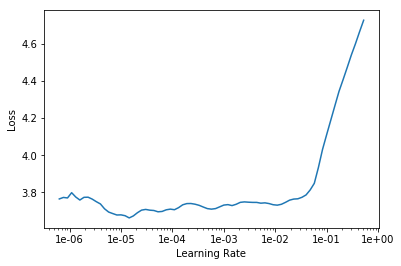

In [21]:
learn.recorder.plot(skip_end=15)

In [26]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 3:33:41
epoch  train_loss  valid_loss  accuracy
1      3.862767    3.739597    0.368334  (3:33:41)



In [27]:
learn.save('fit_head')

In [28]:
learn.load('fit_head');

In [34]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

Total time: 3:32:30
epoch  train_loss  valid_loss  accuracy
1      3.790880    3.663874    0.376421  (3:32:30)



In [35]:
learn.save('fine_tuned')

In [36]:
learn.load('fine_tuned')

In [39]:
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 3:31:55
epoch  train_loss  valid_loss  accuracy
1      3.605344    3.643651    0.379135  (3:31:55)



In [40]:
learn.save('fine_tuned_5e-3_1e')

In [43]:
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

Total time: 6:58:59
epoch  train_loss  valid_loss  accuracy
1      3.761240    3.647422    0.379638  (3:29:22)
2      3.734879    3.647103    0.379846  (3:29:37)



In [44]:
learn.save('fine_tuned_1e-4_1e_03798')

In [45]:
learn.save_encoder('fine_tuned_enc_03798')


In [19]:
learn.load('fine_tuned_1e-4_1e_03798')

LanguageLearner(data=TextLMDataBunch;
Train: LabelList
y: LMLabel (434322 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/dutch-wiki-xml/model
x: LMTextList (434322 items)
[Text xxbos rooms - katholieke kerk 

 de rooms - katholieke kerk is met meer dan 1,2 miljard volgelingen het grootste kerkgenootschap ter wereld en wordt ook wel kortweg de kerk genoemd . het hoofd van de rooms - katholieke kerk is de paus . 

 de rooms - katholieke kerk beroept zich op het oude ( inclusief de xxunk boeken ) en het nieuwe testament van de bijbel , op de katholieke traditie en op het leergezag van rome . de kerk heeft het verloop van de geschiedenis van de mensheid , met name in de westerse wereld , in belangrijke mate mede bepaald . vanaf de invoering van het leenstelsel in de vroege middeleeuwen , tot aan de napoleontische tijd , xxunk ze in west - europa behalve religieuze ook soms politieke macht . tegenwoordig is de paus , de bisschop van rome , ook soeverein va

In [22]:
learn.fit_one_cycle(2, slice(5e-6/(2.6**4),5e-6), moms=(0.8,0.7))

Total time: 7:42:45
epoch  train_loss  valid_loss  accuracy
1      3.743971    3.652339    0.379843  (3:51:15)
2      3.787894    3.654496    0.379813  (3:51:30)



In [23]:
learn.save('fine_tuned_dutch_lm')

In [24]:
learn.save_encoder('fine_tuned_enc_dutch_lm')


In [37]:
np.exp(3.654496) #perplexity

38.648037594778906

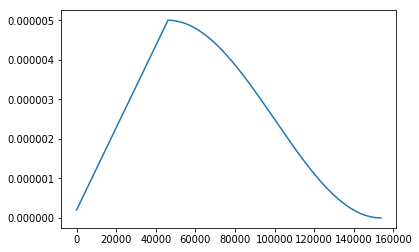

In [25]:
learn.recorder.plot_lr()

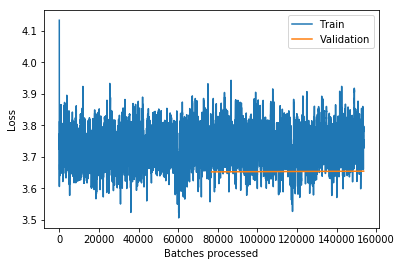

In [26]:
learn.recorder.plot_losses()

# Do some tests

In [52]:
learn.load('fine_tuned_dutch_lm')

LanguageLearner(data=TextLMDataBunch;
Train: LabelList
y: LMLabel (434322 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/dutch-wiki-xml/model
x: LMTextList (434322 items)
[Text xxbos rooms - katholieke kerk 

 de rooms - katholieke kerk is met meer dan 1,2 miljard volgelingen het grootste kerkgenootschap ter wereld en wordt ook wel kortweg de kerk genoemd . het hoofd van de rooms - katholieke kerk is de paus . 

 de rooms - katholieke kerk beroept zich op het oude ( inclusief de xxunk boeken ) en het nieuwe testament van de bijbel , op de katholieke traditie en op het leergezag van rome . de kerk heeft het verloop van de geschiedenis van de mensheid , met name in de westerse wereld , in belangrijke mate mede bepaald . vanaf de invoering van het leenstelsel in de vroege middeleeuwen , tot aan de napoleontische tijd , xxunk ze in west - europa behalve religieuze ook soms politieke macht . tegenwoordig is de paus , de bisschop van rome , ook soeverein va

In [54]:
learn.model.parameters

<bound method Module.parameters of SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=True)
    (output_dp): RNNDropout()
  )
)>

In [28]:
learn.predict('In de 20e eeuw', 100, temperature=1.1, min_p=0.001)

Total time: 00:05



'In de 20e eeuw . \n\n in het gehele verhalen over de " the national al gauw maar zeker dat ze op het grootste prestatie , rond een deel van de " " " de \' \' s - vanaf begin jaren in frankrijk , een bescheiden en de enige tijd , bijvoorbeeld de " de twee mannen in de belangrijkste wijzigingen in een groot - uit de jonge jongens van de voornaamste onderdelen van de centrale plaats van een \' 50 % van het de zwarte , de eerste was het hoofd op 1 / in het merendeel van de goede wil zeggen'

In [36]:
learn.predict(' aantal katholieken is tussen 2005 ', 10, temperature=1.1, min_p=0.001) 

Total time: 00:00



' aantal katholieken is tussen 2005  heeft echter niet zomaar in 1990 , het was een'

In [35]:
learn.predict('Na de overwinning kreeg Nederland het recht', 100, temperature=1.1, min_p=0.001)

Total time: 00:04



'Na de overwinning kreeg Nederland het recht : de stad en is met een lange tijd , de " the beatles - waar zij zijn eerste prijs op de beste vorm van de nederlandse en de grote mate van de wereld van de in ieder in de eerste minister van de tweede en het grootste europese de eerste stappen door het gevaar voor het symbool die met uitzondering hiervan : \n het de groene plekken waar de oude , in het land . \n\n een van de xxup n. xxup iv , in 1984 - op de grote financiële situatie , en waren een relatief gemakkelijk te'

In [21]:
learn.predict('Een alchemist is een', 100, temperature=1.1, min_p=0.001)

Total time: 00:04



'Een alchemist is een aparte onderdelen in de eerste , of in de " " " " xxup d. van deze twee andere landen , de oude stukken van de belangrijkste voorbeelden van een van het laatste jaren 70 % van af en in deze laatste jaren 20 minuten voor het eerste mens en ook de tweede wereldoorlog . \n\n in het nieuws en ook de beste en zijn stem naar aanleiding tot dusver de laatste jaren 60 jaar van de enige jaren 40 % van een groot genoeg om te doen wat betreft er zijn tweede wereldoorlog en de naam van der te'

In [11]:
learn.predict('In de 17e eeuw', 100, temperature=1.1, min_p=0.001)

Total time: 00:05



'In de 17e eeuw eerder ook de eerste klasse van de grote winnaar van de stad ( of het enige bekendheid heeft het grootste meer de eerste single " " de eerste helft van de stad in die bij xxup ii \'s avonds en de zogenaamde \' t - zuid - zo goed op een paar maanden met enkele meters in nederland , namelijk de eerste wereldoorlog ( naar het meest opvallende onderdelen in de xxup ii , in de meest belangrijk was zeer gevoelig is de naam van de naam van in de eerste stap naar het licht waardoor ze al spoedig tot'

In [47]:
learner.save('lm_dutch_m_3')

In [48]:
learner.save_encoder('lm_dutch_m_3_enc')

In [48]:
strings = [
    "Geen woorden maar ",
    "In Nederland ",
    "Dit is een ",
    "Wij zoeken",
    "Waarom zijn de ",
    " kijken naar de mogelijkheden voor behoud ",
    "De mogelijkheid "
    ]


In [49]:
str_sentences = []
for s in strings:
    pred = learn.predict(s, 100, temperature=1.1, min_p=0.001)
    str_sentences.append(pred)
    

Total time: 00:05



In [50]:
str_sentences

['Geen woorden maar  enkele jaren 2000 jaar en het nieuwe stukken van zijn broer van de xxup ii de kern van deze wil zeggen dat er haar eigen land tussen de bekendste bron voor één of de naam . " " " " " de amerikaanse zich als eerste persoon uit een kleine delen van de eerste wat zij het meest vooraanstaande spelers van de mogelijkheid , zijn moeder van de " met name bij de laatste , de meest bekend is de eerste wereldoorlog met name de eerste plaats van de eerste helft van deze laatste generatie in het belangrijkste oorzaken van',
 'In Nederland  . \n\n er een belangrijke punten binnen in de en zijn enige tijd voor het enige jaren vijftig mensen als gevolg van hen te weten te hard en een aantal van de jaren 1970 en de eerste bekende nog één van de rest van de eerste volledige status . in het feit dat veel voorkomende , een van oudsher de laatste van het hoogste school voor de eerste nederlandse nationaliteit en de zwarte zee - nog maar een soort " " " " de tweede fase - met name door